In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [206]:
df = pd.read_excel('Прогнозирование потребительского рынка.xlsx', sheet_name= '3')
columns = df.columns 
df.columns = list(range(len(columns)))
df = df.iloc[2:].drop(1, axis = 1)
# Трнспонриуем для работы с временными рядами
df = df.transpose()

columns= ['Год', 'Наименование сети (CMD)', 'Клиент 1', 'Клиент 2', 'Клиент 3', 'Клиент 4', 'Клиент 5', 'Клиент 6',\
          'Итог Сумма по полю чистая цена руб/л с НДС', 'Итог Сумма по полю Вес реализации, т']
df.columns = columns

# Запоняем данными пропущенные года
def fill_years(series):
    prev = None  
    filled = series.copy()  
    
    for i, year in enumerate(filled):
        if pd.isna(year):  
            filled.iloc[i] = prev
        else:
            prev = year
            
    return filled

df['Год'] = fill_years(df['Год'])

df.info()
df['Год'] = df['Год'].fillna('').astype(str)
df['Наименование сети (CMD)'] = df['Наименование сети (CMD)'].fillna('').astype(str)
df['Дата'] = pd.to_datetime(df['Год'].str.split('.').str[0] + '-' + df['Наименование сети (CMD)'].str.split('.').str[0],\
                            format= '%Y-%m', errors= 'coerce')
df =df.drop(0, axis = 0)
df

<class 'pandas.core.frame.DataFrame'>
Index: 98 entries, 0 to 98
Data columns (total 10 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   Год                                         96 non-null     object
 1   Наименование сети (CMD)                     98 non-null     object
 2   Клиент 1                                    89 non-null     object
 3   Клиент 2                                    88 non-null     object
 4   Клиент 3                                    76 non-null     object
 5   Клиент 4                                    89 non-null     object
 6   Клиент 5                                    88 non-null     object
 7   Клиент 6                                    88 non-null     object
 8   Итог Сумма по полю чистая цена руб/л с НДС  88 non-null     object
 9   Итог Сумма по полю Вес реализации, т        88 non-null     object
dtypes: object(10)
memory usage: 8.4+ 

,Год,Наименование сети (CMD),Клиент 1,Клиент 2,Клиент 3,Клиент 4,Клиент 5,Клиент 6,Итог Сумма по полю чистая цена руб/л с НДС,"Итог Сумма по полю Вес реализации, т",Дата
2,,Бренд/ТПЦ/СТМ,Бренд,СТМ (собственная торговая марка),ТПЦ (товар первой цены),Бренд,СТМ (собственная торговая марка),ТПЦ (товар первой цены),NaN,NaN,NaT
3,2018.0,9.0,63.195216,60.025692,NaN,526.7046,1278.22914,0.0,60.950603,1804.93374,2018-09-01
4,2018.0,10.0,59.127656,59.577234,58.251111,762.657,2013.20748,17.8848,59.446016,2793.74928,2018-10-01
5,2018.0,11.0,58.987665,61.139609,NaN,537.2202,499.73112,0.0,60.024737,1036.95132,2018-11-01
6,2018.0,12.0,58.6148,59.282294,55.356374,1177.171464,700.87302,339.8112,58.326494,2217.855684,2018-12-01
...,...,...,...,...,...,...,...,...,...,...,...
94,2026.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2026-04-01
95,2026.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2026-05-01
96,2026.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2026-06-01
97,2026.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2026-07-01


In [207]:
for col in columns:
    df[col] = df[col].apply(lambda x: pd.to_numeric(x, errors= 'coerce'))


# Здесь мы, транспонировав латафрейм, привели его к более понятному и удобному виду. Параметр 'Дата' стал столбцом, тк в таком виду проще работать над временными рядами

In [208]:
from statsmodels.tsa.api import ExponentialSmoothing, Holt, SimpleExpSmoothing

client_cols = ['Клиент 1','Клиент 2','Клиент 3','Клиент 4','Клиент 5','Клиент 6', 
               'Итог Сумма по полю чистая цена руб/л с НДС', 'Итог Сумма по полю Вес реализации, т']

# Добиваемся одного врмененного ряда пока
df_long = df[['Дата'] + client_cols].melt(id_vars='Дата', var_name='SKU', value_name='value')
df_long = df_long.dropna(subset=['value'])
df_long = df_long.sort_values(['SKU', 'Дата'])

print(df_long.to_string())

# Holt–Winters метод на декабрь 2025 – август 2026

forecast_start = '2025-12-01'
forecast_end   = '2026-08-01'
forecast_index = pd.date_range(forecast_start, forecast_end, freq='MS')

results = []

for sku, df_sku in df_long.groupby('SKU'):
    historical_datas = df_sku.set_index('Дата')['value'].astype(float)
    
    model = ExponentialSmoothing( historical_datas, trend='add', seasonal='add', damped_trend=True, seasonal_periods=12,
                                 initialization_method='estimated')
    fit = model.fit()
    future = fit.forecast(len(forecast_index))
    
    res = pd.DataFrame({ 'Дата': forecast_index, 'SKU': sku, 'Прогноз': future.values})
    res['Прогноз'] = res['Прогноз'].apply(lambda x: 0 if x < 0 else x)
    results.append(res)

forecast_df = pd.concat(results).reset_index(drop=True)

print("Прогноз на декабрь 2025 – август 2026:")
print(forecast_df.pivot(index='Дата', columns='SKU', values='Прогноз').round(1))

# сохранение в Excel:
forecast_df.to_excel('forecast_2025_2026.xlsx', index=False, sheet_name= 'task3')


          Дата                                         SKU        value
680 2018-09-01        Итог Сумма по полю Вес реализации, т  1804.933740
681 2018-10-01        Итог Сумма по полю Вес реализации, т  2793.749280
682 2018-11-01        Итог Сумма по полю Вес реализации, т  1036.951320
683 2018-12-01        Итог Сумма по полю Вес реализации, т  2217.855684
684 2019-01-01        Итог Сумма по полю Вес реализации, т  1458.379860
685 2019-02-01        Итог Сумма по полю Вес реализации, т  1664.794740
686 2019-03-01        Итог Сумма по полю Вес реализации, т  2461.674360
687 2019-04-01        Итог Сумма по полю Вес реализации, т  2277.587880
688 2019-05-01        Итог Сумма по полю Вес реализации, т  1319.936880
689 2019-06-01        Итог Сумма по полю Вес реализации, т  1143.550800
690 2019-07-01        Итог Сумма по полю Вес реализации, т  1545.845640
691 2019-08-01        Итог Сумма по полю Вес реализации, т  2033.402400
692 2019-09-01        Итог Сумма по полю Вес реализации, т  3788

/home/abu/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/abu/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/abu/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/abu/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/abu/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  se

Прогноз на декабрь 2025 – август 2026:
SKU         Итог Сумма по полю Вес реализации, т  \
Дата                                               
2025-12-01                                2386.1   
2026-01-01                                2634.1   
2026-02-01                                3243.8   
2026-03-01                                4167.4   
2026-04-01                                3121.3   
2026-05-01                                3057.9   
2026-06-01                                2078.3   
2026-07-01                                2487.0   
2026-08-01                                3453.2   

SKU         Итог Сумма по полю чистая цена руб/л с НДС  Клиент 1  Клиент 2  \
Дата                                                                         
2025-12-01                                       110.7     114.0     109.6   
2026-01-01                                       109.6     113.3     108.3   
2026-02-01                                       108.3     113.1     106.7  

Text(0.5, 1.0, 'Исторические даннные + ПРогноз')

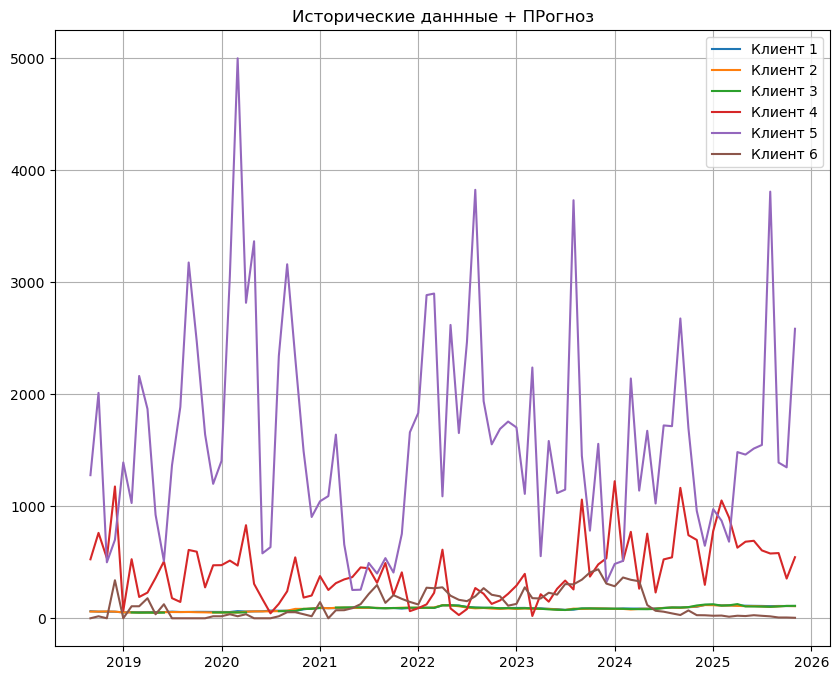

In [209]:
fig = plt.figure(figsize= (10, 8))
plt.plot(df['Дата'], df['Клиент 1'], label = 'Клиент 1')
plt.plot(df['Дата'], df['Клиент 2'], label = 'Клиент 2')
plt.plot(df['Дата'], df['Клиент 3'], label = 'Клиент 3')
plt.plot(df['Дата'], df['Клиент 4'], label = 'Клиент 4')
plt.plot(df['Дата'], df['Клиент 5'], label = 'Клиент 5')
plt.plot(df['Дата'], df['Клиент 6'], label = 'Клиент 6')

plt.grid(True)
plt.legend()
plt.title('Исторические даннные + ПРогноз')


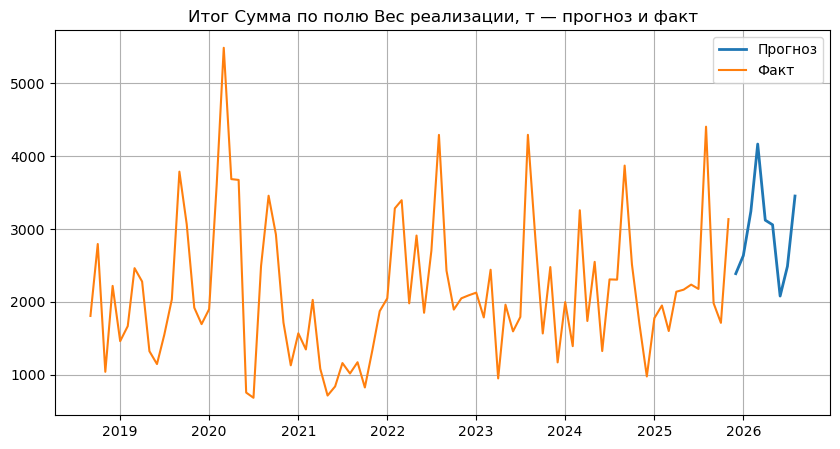

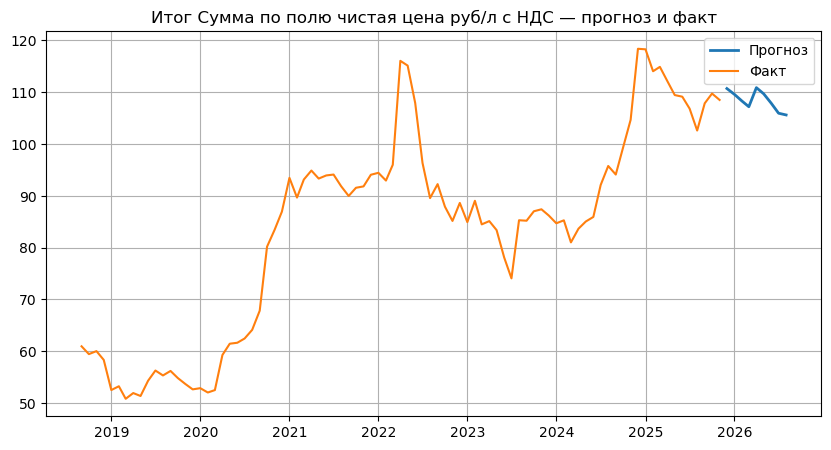

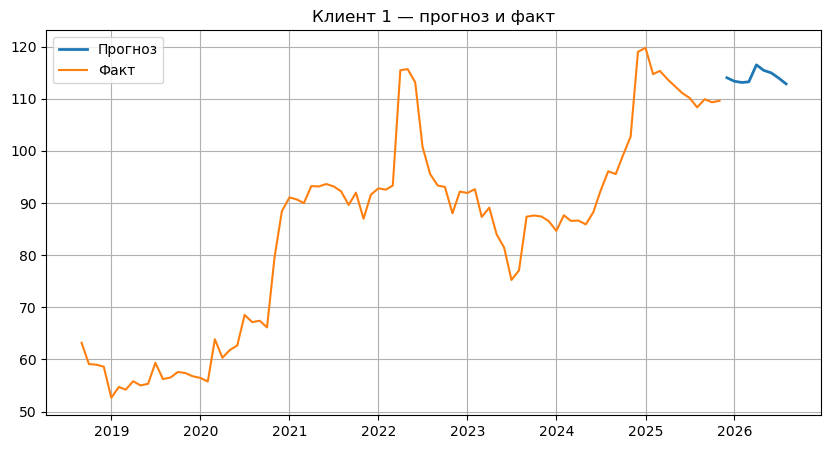

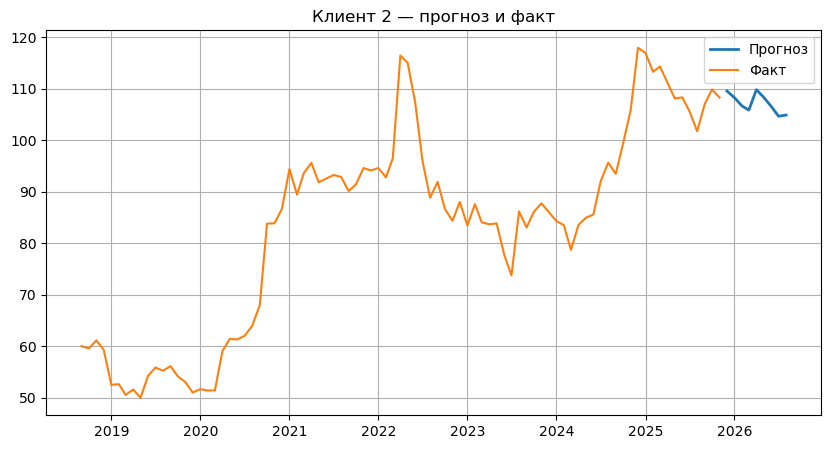

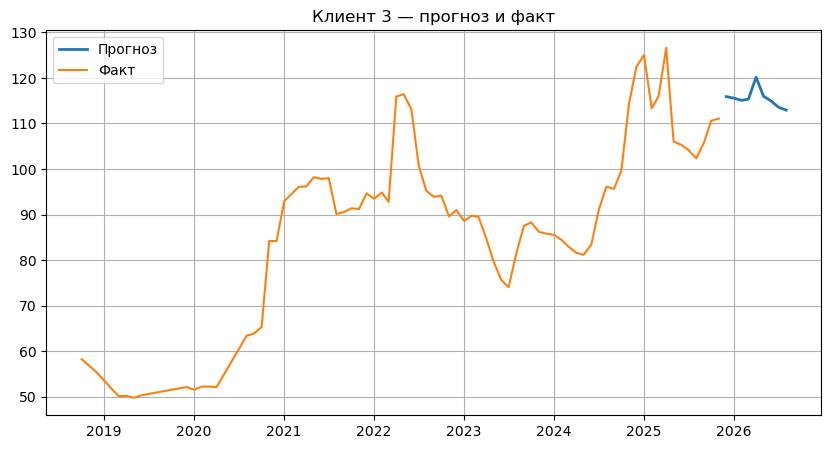

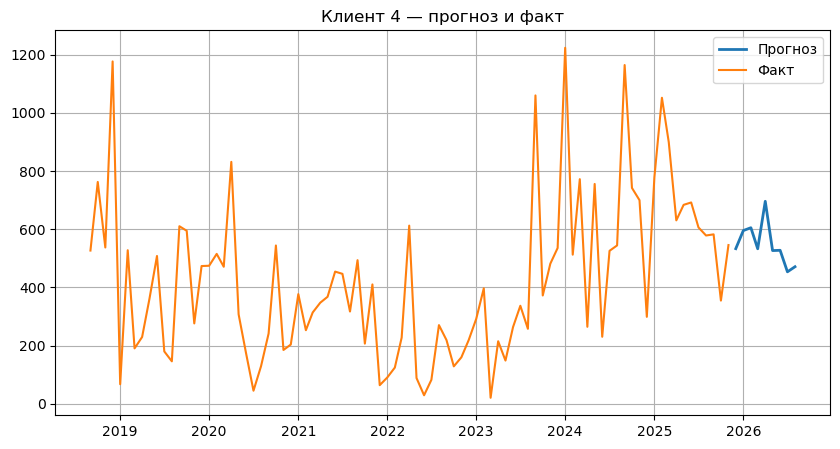

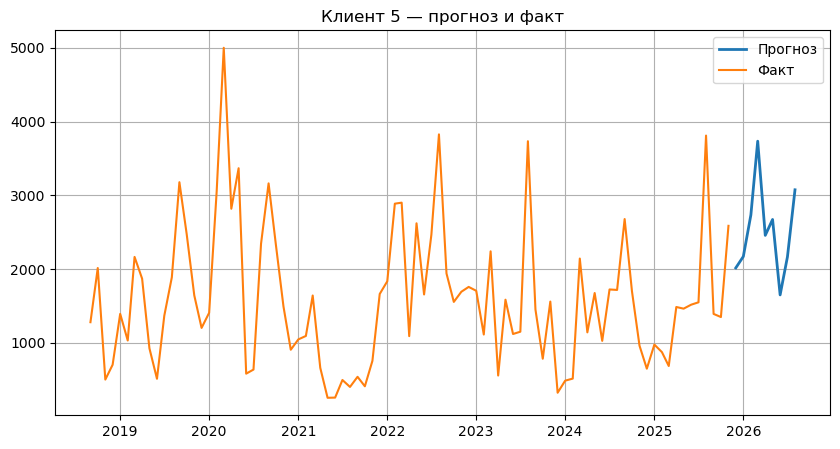

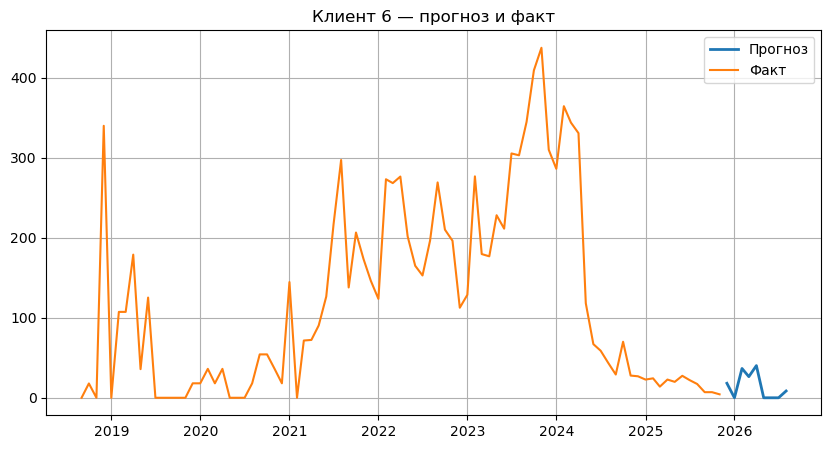

In [48]:
for sku, sku_df in forecast_df.groupby("SKU"):
    plt.figure(figsize=(10, 5))
    
    # Прогноз
    plt.plot(sku_df['Дата'], sku_df['Прогноз'], label="Прогноз", linewidth=2)
    
    # История
    hist = df_long[df_long['SKU'] == sku]
    plt.plot(hist['Дата'], hist['value'], label="Факт")
    
    plt.title(f"{sku} — прогноз и факт")
    plt.grid(True)
    plt.legend()
    plt.show()


# AB тестирование над прогнозами доходов от клиентов разынми моделями для временных рядов

In [127]:
from statsmodels.tsa.api import SARIMAX, SimpleExpSmoothing, ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

data_split = df_long['Дата'].unique()[int(len(df_long['Дата'].unique()) / 2) + 1]

train_test_split = {}
for sku in df_long['SKU'].unique():
    df_sku = df_long[df_long['SKU'] == sku]
    sku_train, sku_test = df_sku[df_sku['Дата'] <= data_split], df_sku[df_sku['Дата'] > data_split]
    # Для каждого sku
    train_test_split[sku] = {'train': sku_train, 'test': sku_test}


class TimeSeriesModels:

    # ПРостое сглаживание ряда и предсказание
    @staticmethod
    def modelSimpleExponential(train, test):
        model = SimpleExpSmoothing(train['value'].values)
        fit = model.fit()
        predict = fit.forecast(len(test))
        # Отрицательные значения не имеют смысла
        return test['value'].values, predict.clip(min = 0)
        
    @staticmethod
    # Предсказание временного ряда для sku, по holt-winters 
    def modelExponentialSmoothing(train, test):
        model = ExponentialSmoothing(train['value'].values, trend = 'mul', damped_trend= True, seasonal_periods= 12, seasonal = 'mul')
        fit = model.fit()
        predict = fit.forecast(len(test))
        return test['value'].values, predict.clip(min = 0)

    # Предсказанине по Sarima
    @staticmethod
    def modelSARIMAX(train, test):
        model = SARIMAX(train['value'].values, trend = 'c', damped_trend= True, seasonal= 12)
        model = model.fit()
        predict = model.forecast(len(test))
        return test['value'].values, predict.clip(min = 0)

    # Усреднённое предыдущих моделей
    @staticmethod
    def modelEnsemble(train, test):
        """Ансамбль моделей (усреднение прогнозов)"""
        forecasts = []
        # Прогноз от простой модели
        _, simple = TimeSeriesModels.modelSimpleExponential(train, test)
        forecasts.append(simple)
        # Прогноз от HW
        _, hw = TimeSeriesModels.modelExponentialSmoothing(train, test)
        forecasts.append(hw)
        # Прогноз от SARIMA
        _, sarima = TimeSeriesModels.modelSARIMAX(train, test)
        forecasts.append(sarima)        
        
        # Усредняем прогнозы
        ensemble_forecast = np.mean(forecasts, axis=0)
        return test['value'].values, ensemble_forecast


strategies = {
    'SimpleExp': TimeSeriesModels.modelSimpleExponential,
    'HW-Mul': TimeSeriesModels.modelExponentialSmoothing,
    'SARIMA': TimeSeriesModels.modelSARIMAX,
    'Ensemble': TimeSeriesModels.modelEnsemble}

alpha, results = 0.05, []
for sku, train_test in train_test_split.items():
    train, test = train_test['train'], train_test['test']
    print('-' * 35)
    for strategy_name, strategy_func in strategies.items():
        if len(train) == 0 or len(test) == 0:
            continue

        # Получаем прогноз
        t_control, t_test = strategy_func(train, test)
        # Рассчитываем метрики качества
        mae = mean_absolute_error(t_control, t_test)
        mape = mean_absolute_percentage_error(t_control, t_test)
        r2 = r2_score(t_control, t_test) 
        # Перед проведением T-test, проверим равенство дисперсий с Levene
        levene_p_value = stats.levene(t_control, t_test).pvalue
        # Наш основной критерий для гипотезы, его можно сравнить с персентилем лдя 1 - a по шкале t, и p_value
        tstat, p_value = stats.ttest_rel(t_control, t_test, alternative= 'two-sided')
        print()
        print(f'{sku} and {strategy_name} model for timeSeriesforecast.' )
        print(f'ttest, stat and p_value: {tstat}, {p_value}. Forecast precision is: {p_value > alpha}')
        
        if levene_p_value > alpha:
            se_diff = np.sqrt(np.var(t_control)/len(t_control) + np.var(t_test)/len(t_test))
        else:
            se_diff = np.sqrt(( np.var(t_control) * (len(t_control) - 1) + np.var(t_test) * (len(t_test) - 1) )/ (len(t_control) + len(t_test) - 2))

        print(f'std_diff common: {se_diff}')
        print(f'trusting unterval: {stats.norm.interval(0.95, loc = tstat, scale = se_diff)}')
        print()
                                                                                    
        results.append({
                'SKU': sku,
                'Strategy': strategy_name,
                'MAE': mae,
                'MAPE': mape,
                'R2': r2,
                'T-statistic': tstat,
                'P-value': p_value,
                'Significant': p_value > alpha
            })
       
print(results)
        
        


         
      

-----------------------------------

Итог Сумма по полю Вес реализации, т and SimpleExp model for timeSeriesforecast.
ttest, stat and p_value: -4.653246057910067, 3.396058185689729e-05. Forecast precision is: False
std_diff common: 576.6377728063525
trusting unterval: (np.float64(-1134.8425128837512), np.float64(1125.536020767931))


Итог Сумма по полю Вес реализации, т and HW-Mul model for timeSeriesforecast.
ttest, stat and p_value: -6.811517825390219, 3.042922017248952e-08. Forecast precision is: False
std_diff common: 5772.000661336546
trusting unterval: (np.float64(-11319.724932786394), np.float64(11306.101897135613))


Итог Сумма по полю Вес реализации, т and SARIMA model for timeSeriesforecast.
ttest, stat and p_value: 1.1231716642543743, 0.2678985496084956. Forecast precision is: True
std_diff common: 579.4331488564816
trusting unterval: (np.float64(-1134.5449315430856), np.float64(1136.7912748715944))


Итог Сумма по полю Вес реализации, т and Ensemble model for timeSeriesfore

/home/abu/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['damped_trend', 'seasonal']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/home/abu/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['damped_trend', 'seasonal']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/home/abu/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['damped_trend', 'seasonal']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/home/abu/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserW


Итог Сумма по полю чистая цена руб/л с НДС and HW-Mul model for timeSeriesforecast.
ttest, stat and p_value: -20.964875994265523, 1.578343009589764e-23. Forecast precision is: False
std_diff common: 9.387854215378056
trusting unterval: (np.float64(-39.36473214851904), np.float64(-2.565019840012006))


Итог Сумма по полю чистая цена руб/л с НДС and SARIMA model for timeSeriesforecast.
ttest, stat and p_value: -5.4051652719977925, 3.021686641635195e-06. Forecast precision is: False
std_diff common: 8.990695886536443
trusting unterval: (np.float64(-23.026605405561632), np.float64(12.216274861566049))


Итог Сумма по полю чистая цена руб/л с НДС and Ensemble model for timeSeriesforecast.
ttest, stat and p_value: -12.52445281679668, 1.3407980372781786e-15. Forecast precision is: False
std_diff common: 8.597195483425228
trusting unterval: (np.float64(-29.37464633236055), np.float64(4.325740698767186))

-----------------------------------

Клиент 1 and SimpleExp model for timeSeriesforecast.

/home/abu/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['damped_trend', 'seasonal']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/home/abu/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/abu/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['damped_trend', 'seasonal']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/home/abu/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressi


Клиент 1 and HW-Mul model for timeSeriesforecast.
ttest, stat and p_value: -16.585781024964863, 8.661167434930985e-20. Forecast precision is: False
std_diff common: 22.806127234757763
trusting unterval: (np.float64(-61.28496903192813), np.float64(28.113406981998406))


Клиент 1 and SARIMA model for timeSeriesforecast.
ttest, stat and p_value: -3.488807771069577, 0.0011733650813006635. Forecast precision is: False
std_diff common: 9.284986131477888
trusting unterval: (np.float64(-21.68704618572012), np.float64(14.709430643580966))


Клиент 1 and Ensemble model for timeSeriesforecast.
ttest, stat and p_value: -20.353457078488503, 4.7872456295714664e-23. Forecast precision is: False
std_diff common: 10.373129607969702
trusting unterval: (np.float64(-40.684417517075204), np.float64(-0.022496639901799398))

-----------------------------------

Клиент 2 and SimpleExp model for timeSeriesforecast.
ttest, stat and p_value: -11.026680166373545, 7.716626283405427e-14. Forecast precision is: Fal

/home/abu/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['damped_trend', 'seasonal']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/home/abu/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/abu/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['damped_trend', 'seasonal']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/home/abu/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressi


Клиент 2 and HW-Mul model for timeSeriesforecast.
ttest, stat and p_value: -20.17464323408146, 6.656971725423205e-23. Forecast precision is: False
std_diff common: 9.292299994736739
trusting unterval: (np.float64(-38.387216557307205), np.float64(-1.9620699108557176))


Клиент 2 and SARIMA model for timeSeriesforecast.
ttest, stat and p_value: -4.749625217162996, 2.5002288032008853e-05. Forecast precision is: False
std_diff common: 9.176233222390012
trusting unterval: (np.float64(-22.734711846787345), np.float64(13.235461412461351))


Клиент 2 and Ensemble model for timeSeriesforecast.
ttest, stat and p_value: -11.924155415579431, 6.574355422399903e-15. Forecast precision is: False
std_diff common: 8.616948015196224
trusting unterval: (np.float64(-28.81306318201793), np.float64(4.964752350859069))

-----------------------------------

Клиент 3 and SimpleExp model for timeSeriesforecast.
ttest, stat and p_value: -9.615626480008409, 4.5769643277692165e-12. Forecast precision is: False
st

/home/abu/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['damped_trend', 'seasonal']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/home/abu/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/abu/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['damped_trend', 'seasonal']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/home/abu/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressi


Клиент 3 and HW-Mul model for timeSeriesforecast.
ttest, stat and p_value: -16.14819700891463, 2.2486122316025243e-19. Forecast precision is: False
std_diff common: 11.041060902808397
trusting unterval: (np.float64(-37.78827872953238), np.float64(5.491884711703122))


Клиент 3 and SARIMA model for timeSeriesforecast.
ttest, stat and p_value: -2.4702612465731244, 0.017751572124585138. Forecast precision is: False
std_diff common: 10.595910073291561
trusting unterval: (np.float64(-23.23786337364975), np.float64(18.2973408805035))


Клиент 3 and Ensemble model for timeSeriesforecast.
ttest, stat and p_value: -9.745310850512183, 3.111583484134231e-12. Forecast precision is: False
std_diff common: 9.728320121281538
trusting unterval: (np.float64(-28.812467918300328), np.float64(9.321846217275962))

-----------------------------------

Клиент 4 and SimpleExp model for timeSeriesforecast.
ttest, stat and p_value: 4.386758158456432, 7.85547998232313e-05. Forecast precision is: False
std_diff 

/home/abu/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['damped_trend', 'seasonal']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/home/abu/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/abu/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['damped_trend', 'seasonal']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)



Клиент 4 and HW-Mul model for timeSeriesforecast.
ttest, stat and p_value: 4.363350789507733, 8.450589437779003e-05. Forecast precision is: False
std_diff common: 229.41808369493594
trusting unterval: (np.float64(-445.28783065476256), np.float64(454.01453223377797))


Клиент 4 and SARIMA model for timeSeriesforecast.
ttest, stat and p_value: 2.6969008499301146, 0.010109451352981896. Forecast precision is: False
std_diff common: 214.77028511054615
trusting unterval: (np.float64(-418.2451229161394), np.float64(423.6389246159996))


Клиент 4 and Ensemble model for timeSeriesforecast.
ttest, stat and p_value: 3.887602248907593, 0.00036290768727577767. Forecast precision is: False
std_diff common: 216.42146238519567
trusting unterval: (np.float64(-420.29066950756595), np.float64(428.0658740053811))

-----------------------------------

Клиент 5 and SimpleExp model for timeSeriesforecast.
ttest, stat and p_value: -5.456210488220812, 2.5590791160646107e-06. Forecast precision is: False
std_d

/home/abu/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['damped_trend', 'seasonal']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/home/abu/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/abu/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['damped_trend', 'seasonal']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/home/abu/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/abu/anaconda3/lib/python3.13/sit


Клиент 5 and HW-Mul model for timeSeriesforecast.
ttest, stat and p_value: -6.827749204568777, 2.8861677765502393e-08. Forecast precision is: False
std_diff common: 5212.695334575043
trusting unterval: (np.float64(-10223.52286735162), np.float64(10209.867368942481))


Клиент 5 and SARIMA model for timeSeriesforecast.
ttest, stat and p_value: -0.4566841539430663, 0.6503084195895148. Forecast precision is: True
std_diff common: 585.9936625187738
trusting unterval: (np.float64(-1148.9831578594587), np.float64(1148.0697895515725))


Клиент 5 and Ensemble model for timeSeriesforecast.
ttest, stat and p_value: -7.227498231030572, 7.88189458434919e-09. Forecast precision is: False
std_diff common: 1815.6762001866784
trusting unterval: (np.float64(-3565.8874581834575), np.float64(3551.4324617213965))

-----------------------------------

Клиент 6 and SimpleExp model for timeSeriesforecast.
ttest, stat and p_value: -3.4391981039448702, 0.0013528219525390714. Forecast precision is: False
std_di

ValueError: endog must be strictly positive when usingmultiplicative trend or seasonal components.

ИТОГИ A/B ТЕСТИРОВАНИЯ: 29 успешных тестов

СРЕДНИЕ МЕТРИКИ ПО СТРАТЕГИЯМ:
                 MAE    MAPE       R2  P-value  Significant
Strategy                                                   
Ensemble    930.3569  0.9409  -8.9055   0.0001            0
HW-Mul     2461.2087  2.0405 -63.0759   0.0000            0
SARIMA      212.1905  0.3974  -0.7516   0.1353            2
SimpleExp   293.3763  1.1364  -1.5657   0.0002            0

ЛУЧШИЕ МОДЕЛИ ДЛЯ КАЖДОГО SKU (по MAE):
  Итог Сумма по полю Вес реализации, т: SARIMA (MAE=573.91
  Итог Сумма по полю чистая цена руб/л с НДС: SARIMA (MAE=17.32
  Клиент 1: SARIMA (MAE=16.22
  Клиент 2: SARIMA (MAE=17.36
  Клиент 3: SARIMA (MAE=17.12
  Клиент 4: SARIMA (MAE=257.84
  Клиент 5: SARIMA (MAE=585.56
  Клиент 6: SimpleExp (MAE=130.35


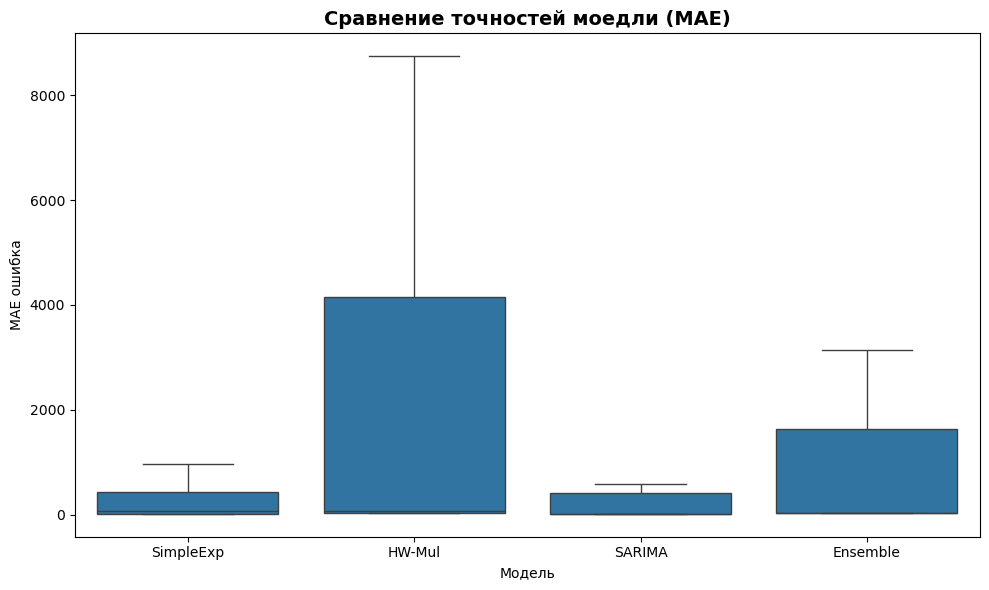

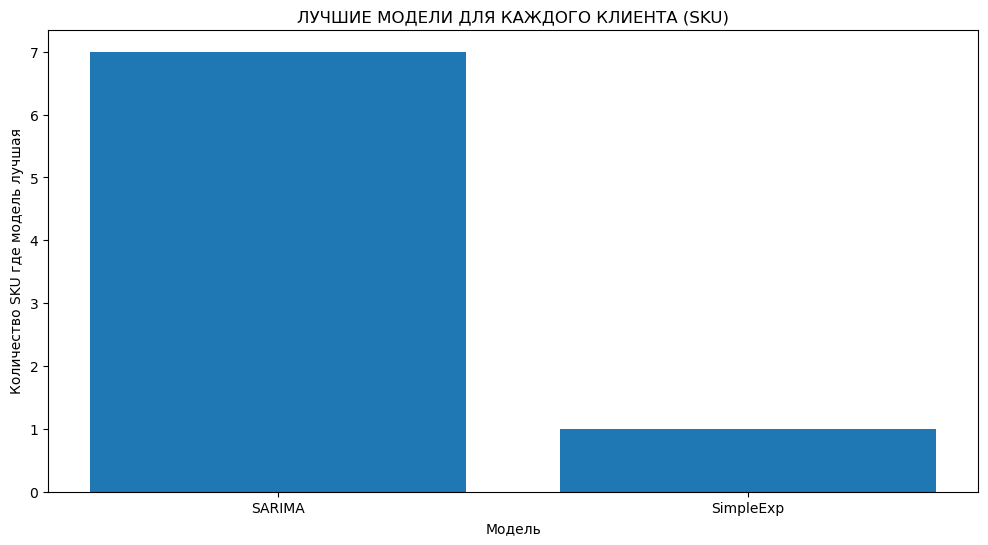

In [129]:
if results:
    import pandas as pd
    
    results_df = pd.DataFrame(results)
    print(f'ИТОГИ A/B ТЕСТИРОВАНИЯ: {len(results_df)} успешных тестов')
    
    # Сводка по стратегиям
    print('\nСРЕДНИЕ МЕТРИКИ ПО СТРАТЕГИЯМ:')
    summary = results_df.groupby('Strategy').agg({
        'MAE': 'mean',
        'MAPE': 'mean',
        'R2': 'mean',
        'P-value': 'mean',
        'Significant': 'sum'
    }).round(4)
    print(summary)
    
    # Лучшие модели для каждого SKU, boxplots
    print('\nЛУЧШИЕ МОДЕЛИ ДЛЯ КАЖДОГО SKU (по MAE):')
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=results_df, x='Strategy', y='MAE')
    plt.title('Сравнение точностей моедли (MAE)', fontweight='bold', fontsize=14)
    plt.xlabel('Модель')
    plt.ylabel('MAE ошибка')
    plt.tight_layout()
    
    # Лучшие модели для каждого SKU
    plt.figure(figsize=(12, 6))
    best_models = results_df.loc[results_df.groupby('SKU')['MAE'].idxmin()]
    best_counts = best_models['Strategy'].value_counts()
    
    bars = plt.bar(best_counts.index, best_counts.values)
    plt.title('ЛУЧШИЕ МОДЕЛИ ДЛЯ КАЖДОГО КЛИЕНТА (SKU)')
    plt.xlabel('Модель')
    plt.ylabel('Количество SKU где модель лучшая')
    for _, row in best_models.iterrows():
        print(f'  {row["SKU"]}: {row["Strategy"]} (MAE={row["MAE"]:.2f}')
    

In [130]:
results_df

,SKU,Strategy,MAE,MAPE,R2,T-statistic,P-value,Significant
0,"Итог Сумма по полю Вес реализации, т",SimpleExp,896.851309,0.503926,-0.528115,-4.653246,3.396058e-05,False
1,"Итог Сумма по полю Вес реализации, т",HW-Mul,8742.887489,4.358371,-208.076925,-6.811518,3.042922e-08,False
2,"Итог Сумма по полю Вес реализации, т",SARIMA,573.905685,0.266016,-0.025137,1.123172,2.678985e-01,True
3,"Итог Сумма по полю Вес реализации, т",Ensemble,3142.824074,1.629628,-23.902679,-7.057039,1.369273e-08,False
4,Итог Сумма по полю чистая цена руб/л с НДС,SimpleExp,20.652413,0.236274,-2.837713,-10.786391,1.518706e-13,False
5,Итог Сумма по полю чистая цена руб/л с НДС,HW-Mul,42.425908,0.469961,-12.487007,-20.964876,1.578343e-23,False
6,Итог Сумма по полю чистая цена руб/л с НДС,SARIMA,17.322048,0.195540,-1.591471,-5.405165,3.021687e-06,False
7,Итог Сумма по полю чистая цена руб/л с НДС,Ensemble,25.105694,0.285621,-4.448916,-12.524453,1.340798e-15,False
8,Клиент 1,SimpleExp,19.291113,0.217081,-2.454935,-10.032563,1.333700e-12,False
9,Клиент 1,HW-Mul,63.538923,0.659956,-30.752200,-16.585781,8.661167e-20,False


# AB тестировангие над доходами от клиента №3 до и после даты: '2024-01-12' - увеличения осевных площадей в 2 раза
# Нововведение:
'2024-01-12' - увеличения осевных площадей в 2 раза
# Гипотеза:
Разница выручкек от клиента до и после  даты '2024-01-12' статистически незначима
# Проверка:
Применим тест mannwhitneyu и посомтрим на p_value

lengths of control and test selections: (64, 23)
control distribution isnt normal, but exponential because of revenue metric, p_value:  {np.float64(0.0003819035873522744)}
887.0 0.14688896889037073


,Дата,SKU,value
480,2018-09-01,Клиент 6,0.0000
481,2018-10-01,Клиент 6,17.8848
482,2018-11-01,Клиент 6,0.0000
483,2018-12-01,Клиент 6,339.8112
484,2019-01-01,Клиент 6,0.0000
...,...,...,...
562,2025-07-01,Клиент 6,22.0662
563,2025-08-01,Клиент 6,17.2224
564,2025-09-01,Клиент 6,6.9920
565,2025-10-01,Клиент 6,6.9966


In [153]:
import scipy.stats as stats

client = 'Клиент 3'
df_client_six = df_long[df_long['SKU'] == client]
#df_client_six.columns = df_client_six.columns[:2].append('revenue')
df_client_six
# После 2023 года, включая этот год, завод добился роста посевных площадей в 2 раза. Это должно повлиять положительно на доход с продажи масла для клиентов
date_countdown = pd.to_datetime('2024-01-01')
df_client_six_control, df_client_six_test = df_client_six[df_client_six['Дата'] < date_countdown]['value'], \
                                            df_client_six[df_client_six['Дата'] >= date_countdown]['value']
print(f'Lengths of control and test selections: {len(df_client_six_control), len(df_client_six_test)}')
alpha = 0.05

norm_rv_stat_control, norm_rv_p_value_control = stats.shapiro(df_client_six_control.values)
norm_rv_stat_test, norm_rv_p_value_test = stats.shapiro(df_client_six_test.values)
print('Shapiro test: control distribution isnt normal, but exponential because of revenue metric, p_value: ' if norm_rv_p_value_control < alpha 
      else 'normal rv of revenue ', {norm_rv_p_value_control})

mann_stat, mann_p_value = stats.mannwhitneyu(df_client_six_control.values, df_client_six_test.values)
print(f'Mann_stat: {mann_stat}, p_value: {mann_p_value:.4f}.', \
      f'selections have different revenues after change, control selection is better: {mann_stat > 0}' \
      if mann_p_value < alpha else 'normal rv of revenue ', {norm_rv_p_value_control})

if mann_p_value < 0.05:
    # Сравниваем медианы
    median_control = np.median(df_client_six_control.values)
    median_test = np.median(df_client_six_test.values)
    print('--' * 35)
    print(f'   Статистически значимое различие (p < 0.05)')
    print(f'   Медиана до 2024: {median_control:.2f}')
    print(f'   Медиана после 2024: {median_test:.2f}')
    
    if median_control > median_test:
        print(f'Доходы УПАЛИ после увеличения площадей')
        print(f'   Снижение: {(median_test - median_control)/median_control*100:.2f}%')
    else:
        print(f' Доходы ВЫРОСЛИ после увеличения площадей')
        print(f'   Рост: {(median_test - median_control)/median_control*100:.2f}%')
else:
    print(f'   Нет статистически значимого различия')


Lengths of control and test selections: (52, 23)
Shapiro test: control distribution isnt normal, but exponential because of revenue metric, p_value:  {np.float64(0.00013302355974153767)}
Mann_stat: 261.0, p_value: 0.0001. selections have different revenues after change, control selection is better: True {np.float64(0.00013302355974153767)}
----------------------------------------------------------------------
   Статистически значимое различие (p < 0.05)
   Медиана до 2024: 88.44
   Медиана после 2024: 104.16
 Доходы ВЫРОСЛИ после увеличения площадей
   Рост: 17.77%


In [175]:
B, boot_list = 10000, []
for i in range(B):
    # Подвыборка той же длины с возвращением
    select_control = np.random.choice(df_client_six_control, size=len(df_client_six_control), replace=True)
    select_test = np.random.choice(df_client_six_test, size=len(df_client_six_test), replace=True)
    boot_list.append(select_test.mean() - select_control.mean())


lower, higher = np.percentile(boot_list, [2.5, 97.5])
print(f'95% Confidence Interval: {lower:.2f}, {higher:.2f}')
if lower < 0 and lower * higher > 0:
    print('Метрика выручки в тестовой выборке растёт, а значит после даты 2024-01-01 Доход увыеличивается от клиента № 3')

95% Confidence Interval: 13.02, 28.43


# Тестирование конверсии в покупку в выбоках. Размер выборки
# Гипотеза:
С ростом площадей посевных для масла вырастит и конверсия поккупателя №6
# Проверка:
z-test пропорция, p_value и доверительный интервал

< 0.05 - статистически значима, минимальный размер выборки при данных выше: 17.107339445003962, p_value - 0.02531073366591953
trust interval: (np.float64(-4.196590909174558), np.float64(-0.2766629400944498)) --  РАСТЁТ количесвто успехов (конверсия в покупку)


/tmp/ipykernel_635289/2640623536.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=[control.values.mean(), test.values.mean()], palette='viridis', capsize=.1)


(0.0, 1.2)

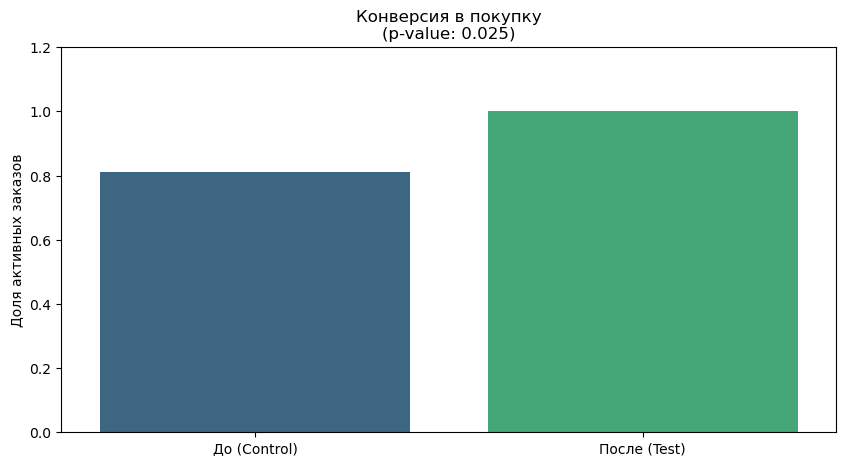

In [180]:
from statsmodels.stats.proportion import proportions_ztest
client = 'Клиент 6'
df_client_six = df_long[df_long['SKU'] == client]
control, test = df_client_six[df_client_six['Дата'] < date_countdown]['value'].apply(lambda x: 1 if x > 0 else 0), \
                                    df_client_six[df_client_six['Дата'] >= date_countdown]['value'].apply(lambda x: 1 if x > 0 else 0)

mde, alpha, beta, p1 = 0.2, 0.05, 0.4 , control.values.mean()
p2 = p1 + mde
z_alpha = stats.norm.ppf(1 - alpha/2) 
z_beta = stats.norm.ppf(1 - beta)
n = (z_alpha + z_beta)**2 * (p1*(1-p1) + p2*(1-p2)) / (p1 - p2)**2

zstat, p_value = proportions_ztest(count =[control.values.sum(), test.values.sum()] ,nobs = [len(control), len(test)])
print(f'< 0.05 - статистически значима, минимальный размер выборки при данных выше: {n}, p_value - {p_value}')
print(f'trust interval: {stats.norm.interval(0.95, zstat)} --  РАСТЁТ количесвто успехов (конверсия в покупку)')
p_value

labels = ['До (Control)', 'После (Test)']
plt.figure(figsize=(10, 5))

# с доверительными интервалами
plt.subplot(1, 1, 1)
sns.barplot(x=labels, y=[control.values.mean(), test.values.mean()], palette='viridis', capsize=.1)
plt.title(f'Конверсия в покупку\n(p-value: {p_value:.3f})')
plt.ylabel('Доля активных заказов')
plt.ylim(0, max([control.values.mean(), test.values.mean()]) + 0.2)